# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости. 

Основные факторы при выборе модели:

- качество предсказания;
- скорость предсказания;
- время обучения.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ моделей</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Решающее-дерево" data-toc-modified-id="Решающее-дерево-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Решающее дерево</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#Проверка-на-тестовых-данных" data-toc-modified-id="Проверка-на-тестовых-данных-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Проверка на тестовых данных</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Итоговый-вывод" data-toc-modified-id="Итоговый-вывод-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Итоговый вывод</a></span></li></ul></div>

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor, Pool, cv
from lightgbm import LGBMRegressor
RS = 12345

warnings.filterwarnings('ignore')
sns.set_style()
sns.set(color_codes=True)
plt.rcParams['figure.figsize'] = 10.0, 6.0

In [2]:
df = pd.read_csv('/datasets/autos.csv')

Рассмотрим первые 5 строк в таблице:

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Рассмотрим основную информацию о таблице:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Согласно документации к данным:

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

Избавимся от столбцов, которые не дают никакой полезной информации для построения модели:

In [5]:
df = df.drop(['DateCrawled',
              'RegistrationMonth',
              'NumberOfPictures',
              'PostalCode',
              'LastSeen',
              'DateCreated'], axis=1)

In [6]:
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes
354365,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


Рассмотрим основные описательные статистики:

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0


Избавимся от дубликатов:

In [8]:
df.drop_duplicates(inplace=True)

Рассмотрим пропущенные значения:

In [9]:
df.isna().sum()

Price                   0
VehicleType         34559
RegistrationYear        0
Gearbox             17207
Power                   0
Model               18361
Kilometer               0
FuelType            30764
Brand                   0
NotRepaired         64558
dtype: int64

Заметим, что пропуски содержатся только для столбцов с категориальными типами.

Создадим список со столбцами, содержащими категориальный тип данных. В дальнейшим он нам пригодится для использования библиотеки **CatBoost**.

In [10]:
cat = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired', 'Brand']

In [11]:
for col in cat:
    print(f'Распределение для столбца {col}')
    display(df[col].value_counts(dropna=False))
    df[col].fillna('no_info', inplace=True)

Распределение для столбца VehicleType


sedan          78206
small          67548
wagon          56367
NaN            34559
bus            25830
convertible    18195
coupe          14690
suv            10776
other           3158
Name: VehicleType, dtype: int64

Распределение для столбца Gearbox


manual    232774
auto       59348
NaN        17207
Name: Gearbox, dtype: int64

Распределение для столбца Model


golf                  23639
other                 22934
NaN                   18361
3er                   16700
polo                  10494
                      ...  
kalina                    7
rangerover                4
serie_3                   4
serie_1                   2
range_rover_evoque        1
Name: Model, Length: 251, dtype: int64

Распределение для столбца FuelType


petrol      187848
gasoline     84794
NaN          30764
lpg           4888
cng            524
hybrid         222
other          200
electric        89
Name: FuelType, dtype: int64

Распределение для столбца NotRepaired


no     211328
NaN     64558
yes     33443
Name: NotRepaired, dtype: int64

Распределение для столбца Brand


volkswagen        63907
opel              33957
bmw               31716
mercedes_benz     28696
audi              25470
ford              22400
renault           15798
peugeot            9808
fiat               8675
seat               6188
mazda              5113
skoda              4967
smart              4823
citroen            4798
nissan             4489
toyota             4248
hyundai            3295
sonstige_autos     2931
volvo              2907
mini               2866
mitsubishi         2812
honda              2637
kia                2247
suzuki             2158
alfa_romeo         2142
chevrolet          1648
chrysler           1352
dacia               830
daihatsu            752
subaru              726
porsche             699
jeep                639
trabant             555
daewoo              508
land_rover          507
saab                484
jaguar              479
rover               449
lancia              443
lada                210
Name: Brand, dtype: int64

Исследуем линейную взаимосвязь между ценой и остальными параметрами:

In [12]:
df.corr()

,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.025714,0.147634,-0.325592
RegistrationYear,0.025714,1.000000,-0.000896,-0.052516
Power,0.147634,-0.000896,1.000000,0.026446
Kilometer,-0.325592,-0.052516,0.026446,1.000000


Построим график распределения для столбцов с числовыми данными:

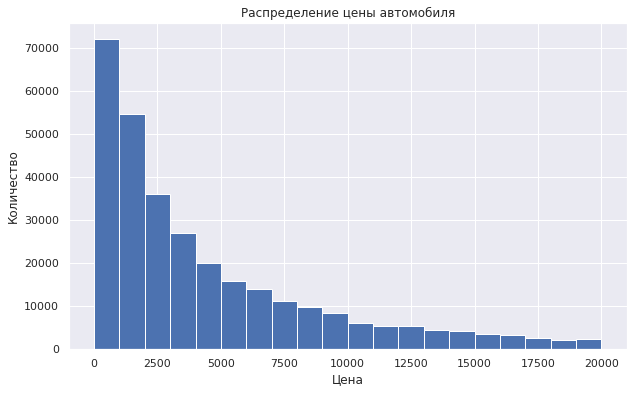

In [13]:
df.Price.hist(bins=20)
plt.title('Распределение цены автомобиля')
plt.xlabel('Цена')
plt.ylabel('Количество')
plt.show()

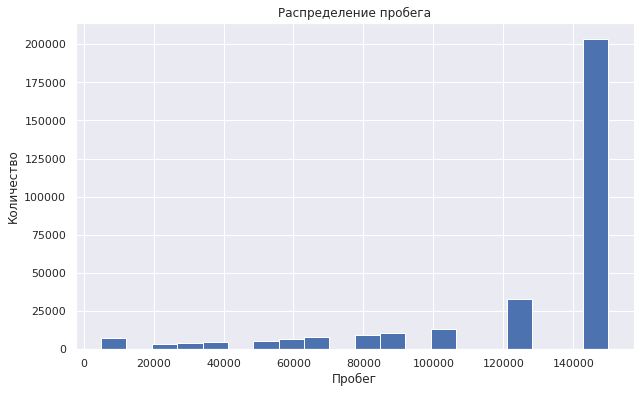

In [14]:
df.Kilometer.hist(bins=20)
plt.title('Распределение пробега')
plt.xlabel('Пробег')
plt.ylabel('Количество')
plt.show()

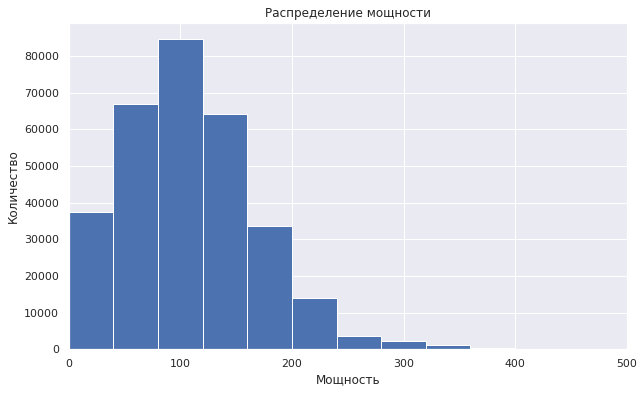

In [15]:
df.Power.hist(bins=500)
plt.xlim(0, 500)
plt.title('Распределение мощности')
plt.xlabel('Мощность')
plt.ylabel('Количество')
plt.show()

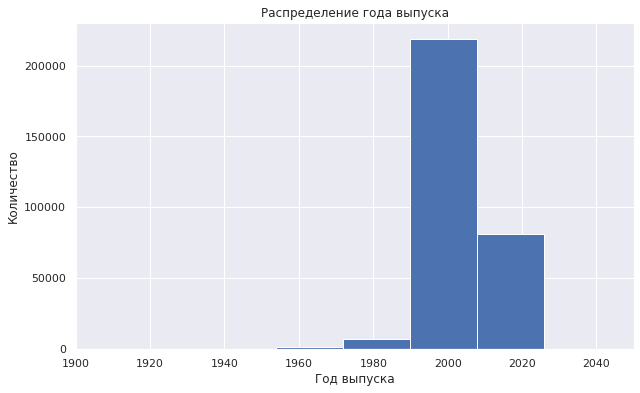

In [16]:
df.RegistrationYear.hist(bins=500)
plt.xlim(1900, 2050)
plt.title('Распределение года выпуска')
plt.xlabel('Год выпуска')
plt.ylabel('Количество')
plt.show()

Заметим, что в графе с ценой и мощностью имеются нулевые значения - избавимся от них. Также установим адекватные минимальные границы по мощности и цене:

In [17]:
df_filtered = df.query('Power > 50 & Price > 50')

Рассмотрим какое процент данных от первоначального значения удалось сохранить:

In [18]:
len(df_filtered) / len(df)

0.8342897044893948

Для взаимодействия с большинством библиотек, кроме **CatBoost** необходимо преобразовать категориальные данные в числовые методом **OHE**:

In [19]:
df_models = pd.get_dummies(df_filtered, drop_first=True)

### Вывод

Первоначально можно утверждать, что данных достаточно для исследования. Проведена проверка на пропуски и дубликаты, которые затем были обработаны. Изучены распределения основных числовых параметров. Были отфильтрованы нулевые выбросы. Также к столбцам, содержащим категориальные переменные, была применена техника **OHE**, для того, чтобы модели смогли обработать эти данные.

## Анализ моделей

В данном разделе рассмотрим поведение следующих моделей:

* Линейная регрессия;
* Решающее дерево;
* Случайный лес;
* CatBoost;
* LightGMB.

Так как исследование базовых моделей приведено лишь для сравнения с моделями градиентного бустига, то в них не будем подробно настраивать и оптимизировать гиперпараметры, а будем пользоваться базовыми моделями.

Разобьем данные на тренировочную и тестовую выборки:

In [57]:
X = df_models.drop('Price', axis=1)
y = df_models['Price']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RS)

Для начала рассмотрим то значение исследуемой метрики, которое выдаст случайная модель. Основываясь на полученном результате будем проверять на "глупость" исследуемые модели.

In [59]:
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
predictions = dummy.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, predictions)))

4669.4938026094


### Линейная регрессия

In [60]:
lr = LinearRegression()

In [61]:
%%time

cross_val_score(lr, X_train, y_train, scoring='neg_root_mean_squared_error', cv=3).mean()

CPU times: user 29.2 s, sys: 10.8 s, total: 40 s
Wall time: 40 s


-3193.5898785471313

In [72]:
lr.fit(X_train, y_train)

LinearRegression()

### Решающее дерево

In [62]:
tree = DecisionTreeRegressor(random_state=RS)

In [63]:
%%time

cross_val_score(tree, X_train, y_train, scoring='neg_root_mean_squared_error', cv=3).mean()

CPU times: user 11.8 s, sys: 459 ms, total: 12.3 s
Wall time: 12.4 s


-2100.198507352991

In [73]:
tree.fit(X_train, y_train)

DecisionTreeRegressor(random_state=12345)

### Случайный лес

In [27]:
forest = RandomForestRegressor(random_state=RS)

In [28]:
%%time

cross_val_score(forest, X_train, y_train, scoring='neg_root_mean_squared_error', cv=3).mean()

CPU times: user 11min 23s, sys: 1.79 s, total: 11min 25s
Wall time: 11min 26s


-1716.1649997337306

In [74]:
forest.fit(X_train, y_train)

RandomForestRegressor(random_state=12345)

### LightGBM

In [55]:
lgbm = LGBMRegressor(n_estimators=1000, max_depth=10, learning_rate=0.3)

In [65]:
%%time
cross_val_score(lgbm, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5).mean()

CPU times: user 2min 59s, sys: 2.31 s, total: 3min 2s
Wall time: 3min 4s


-1613.2601695541557

In [67]:
lgbm.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.3, max_depth=10, n_estimators=1000)

### CatBoost

Так как **CatBoost** имеет встроенный функционал для обработки категориальных значений, то признаки и целевую переменную возьмем из изначального датасета:

In [45]:
X = df_filtered.drop('Price', axis=1)
y = df_filtered['Price']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RS)

In [33]:
catboost = CatBoostRegressor()

In [34]:
params = {'iterations': range(1000, 2000, 250),
          'depth': range(5, 12, 2),
          'learning_rate': np.arange(0.1, 0.5, 0.1),
          'verbose': [100]
         }

In [35]:
grid = GridSearchCV(catboost, params, scoring='neg_root_mean_squared_error', cv=3)

In [37]:
grid.fit(X_train, y_train)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 4379.8785391	total: 17ms	remaining: 17s
100:	learn: 1891.7488518	total: 1.66s	remaining: 14.8s
200:	learn: 1786.9381960	total: 3.34s	remaining: 13.3s
300:	learn: 1734.5339495	total: 4.95s	remaining: 11.5s
400:	learn: 1700.5719733	total: 6.54s	remaining: 9.76s
500:	learn: 1676.5087406	total: 8.1s	remaining: 8.07s
600:	learn: 1655.9539006	total: 9.67s	remaining: 6.42s
700:	learn: 1639.2786240	total: 11.4s	remaining: 4.84s
800:	learn: 1624.4844433	total: 13s	remaining: 3.23s
900:	learn: 1612.0019033	total: 14.6s	remaining: 1.61s
999:	learn: 1601.5017656	total: 16.2s	remaining: 0us
0:	learn: 4364.2196061	total: 15.3ms	remaining: 15.3s
100:	learn: 1878.6442655	total: 1.91s	remaining: 17s
200:	learn: 1772.2518671	total: 3.5s	remaining: 13.9s
300:	learn: 1723.5255248	total: 5.18s	remaining: 12s
400:	learn: 1689.9623175	total: 6.84s	remaining: 10.2s
500:	learn: 1665.5524244	total: 8.43s	remaining: 8.39s
600:	learn: 1646.2187109	total: 9.98s	remaining: 6.63s
700:	learn: 1630.3952993	t

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fba2ada1340>,
             param_grid={'depth': range(5, 12, 2),
                         'iterations': range(1000, 2000, 250),
                         'learning_rate': array([0.1, 0.2, 0.3, 0.4]),
                         'verbose': [100]},
             scoring='neg_root_mean_squared_error')

In [38]:
grid.best_params_

{'depth': 11, 'iterations': 1750, 'learning_rate': 0.1, 'verbose': 100}

Обучим модель с наилучшими параметрами:

In [43]:
catboost = CatBoostRegressor(iterations=1750,
                             learning_rate=0.1,
                             depth=11,
                             verbose=100)

In [47]:
catboost.fit(X_train, y_train, cat_features=cat)

0:	learn: 4306.5689060	total: 620ms	remaining: 18m 3s
1:	learn: 4007.8905123	total: 1.17s	remaining: 17m 4s
2:	learn: 3742.0314302	total: 1.63s	remaining: 15m 48s
3:	learn: 3510.3733557	total: 2.07s	remaining: 15m 3s
4:	learn: 3300.5092685	total: 2.48s	remaining: 14m 25s
5:	learn: 3113.4308692	total: 3.02s	remaining: 14m 36s
6:	learn: 2949.9167095	total: 3.55s	remaining: 14m 43s
7:	learn: 2809.7265786	total: 4.01s	remaining: 14m 34s
8:	learn: 2684.0863405	total: 4.5s	remaining: 14m 29s
9:	learn: 2574.2825618	total: 5.04s	remaining: 14m 37s
10:	learn: 2476.6709277	total: 5.51s	remaining: 14m 31s
11:	learn: 2393.4347671	total: 6.05s	remaining: 14m 36s
12:	learn: 2318.9353000	total: 6.62s	remaining: 14m 44s
13:	learn: 2255.2863316	total: 7.12s	remaining: 14m 42s
14:	learn: 2200.6161408	total: 7.58s	remaining: 14m 37s
15:	learn: 2148.9692530	total: 8.03s	remaining: 14m 29s
16:	learn: 2104.7244110	total: 8.52s	remaining: 14m 28s
17:	learn: 2065.3230156	total: 8.96s	remaining: 14m 22s
18:	le

### Проверка на тестовых данных

Проверим время предсказаний:

In [50]:
%%time
prediction = catboost.predict(X_test)

CPU times: user 2.61 s, sys: 0 ns, total: 2.61 s
Wall time: 2.61 s


In [51]:
print(f'RMSE CatBoost Модели составил: {(np.sqrt(mean_squared_error(y_test, prediction)))}')

RMSE CatBoost Модели составил: 1593.7084305296974


In [70]:
%%time
prediction = lgbm.predict(X_test)

CPU times: user 6.91 s, sys: 73.1 ms, total: 6.99 s
Wall time: 6.98 s


In [71]:
print(f'RMSE LightGBM Модели составил: {(np.sqrt(mean_squared_error(y_test, prediction)))}')

RMSE LightGBM Модели составил: 1603.3829391151367


In [75]:
%%time
prediction = lr.predict(X_test)

CPU times: user 130 ms, sys: 77.2 ms, total: 207 ms
Wall time: 175 ms


In [76]:
print(f'RMSE LinearRegression Модели составил: {(np.sqrt(mean_squared_error(y_test, prediction)))}')

RMSE LinearRegression Модели составил: 3181.570296498989


In [77]:
%%time
prediction = tree.predict(X_test)

CPU times: user 72.3 ms, sys: 60.8 ms, total: 133 ms
Wall time: 131 ms


In [78]:
print(f'RMSE DecisionTree Модели составил: {(np.sqrt(mean_squared_error(y_test, prediction)))}')

RMSE DecisionTree Модели составил: 2032.345525579448


In [79]:
%%time
prediction = forest.predict(X_test)

CPU times: user 3.2 s, sys: 48 ms, total: 3.25 s
Wall time: 3.25 s


In [80]:
print(f'RMSE RandomForest Модели составил: {(np.sqrt(mean_squared_error(y_test, prediction)))}')

RMSE RandomForest Модели составил: 1680.4076840541823


Можно было и в цикле это сделать, но нужно узнать время предсказаний

In [88]:
output = pd.DataFrame({'Время обучения': ['34.7 s', '11.7 s', '11min 33s', '2min 35s', '6min 58s'],
              'RMSE_train': [3193.59, 2100.20, 1716.16, 1613.26, 1210.78],
              'Время предсказания': ['175 ms', '131 ms', '3.25 s', '6.98 s', '2.61 s'],
              'RMSE_test': [3181.57, 2032.34, 1680.40, 1603.38, 1593.70]
             }, 
             index=['LinearRegression',
                    'DecisionTreeRegressor',
                    'RandomForestRegressor',
                    'LightGBM',
                    'CatBoost'
                   ]
            )

### Вывод

Таким образом, наилучшее соотношение скорость/качество модели дала библиотека **Catboost** - за 2 мин. 35 сек. показатель метрики **RMSE** составил **1593.70**. Также все модели прошли проверку на адекватность. Показатель остальных моделей приведены в таблице:

In [89]:
output

,Время обучения,RMSE_train,Время предсказания,RMSE_test
LinearRegression,34.7 s,3193.59,175 ms,3181.57
DecisionTreeRegressor,11.7 s,2100.20,131 ms,2032.34
RandomForestRegressor,11min 33s,1716.16,3.25 s,1680.40
LightGBM,2min 35s,1613.26,6.98 s,1603.38
CatBoost,6min 58s,1210.78,2.61 s,1593.70


##  Итоговый вывод

В данной работе были исследованы возможности моделей, основанных на методе градиентного бустинга, таких как **CatBoost** и **LightGBM**. Было проведено сравнение относительно некоторых базовых моделей. Выяснено, что модели градиентого бустинга позволяют получить намного более точное значение исследуемой метрики, что, очевидно, улучшает качество модели. При тонкой настройке гиперпараметров возможно получить крайне точную метрику.